## Task 1: Photometric Stereo (30 pts)

In [1]:
from IPython.display import Image
import numpy as np
import cv2
import sys
from lib.display_helper import *
from lib.log_progress import log_progress

def compute_normals(imgs, L):
    (h, w) = imgs[0].shape
    output_normals = np.zeros((h,w,3), np.float32)
    
    L_inv = np.linalg.inv(L)
    for y in range(0, h):
        for x in range(0, w):
            I = np.array([imgs[0][y,x], imgs[1][y,x], imgs[2][y,x]])
            N = np.dot(L_inv, I)
        
            N_length = np.linalg.norm(N)
            if(N_length != 0):
                N = N/N_length
            else:
                N = N*0.
            output_normals[y,x,0] = N[0]
            output_normals[y,x,1] = -N[1]
            output_normals[y,x,2] = N[2]
    return output_normals

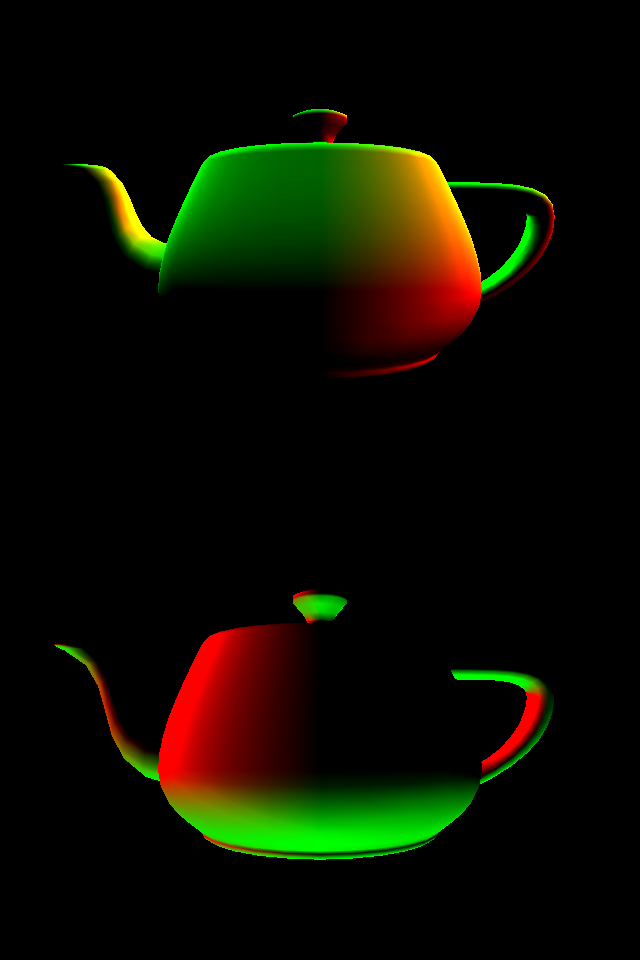

In [2]:
L = np.array([
    [ 0,-1, 1],
    [ 1, 1, 1],
    [-1, 1, 1]
])

teapot0_imgs = [
    cv2.imread('2_photometricstereo/teapot_0_-1_1.png', 0),
    cv2.imread('2_photometricstereo/teapot_1_1_1.png', 0),
    cv2.imread('2_photometricstereo/teapot_-1_1_1.png', 0)
]

normals = compute_normals(teapot0_imgs, L)
normals_y = normals[...,1]*255./(normals[...,2]+sys.float_info.epsilon)
normals_x = normals[...,0]*255./(normals[...,2]+sys.float_info.epsilon)

output_positive_img = np.zeros_like(normals)
output_negative_img = np.zeros_like(normals)

output_positive_img[...,1] = -normals_y
output_positive_img[...,2] = normals_x
output_negative_img[...,1] = normals_y
output_negative_img[...,2] = -normals_x

output_img = multiple_display([[output_positive_img],[output_negative_img]])
output_path = 'output/task1.png'
cv2.imwrite(output_path,output_img)
Image(output_path)

## Task 2: Relighting (30 pts)

In [3]:
from os import listdir
from os.path import isfile, join

teapot_path = '1_relighting/data'
teapot_files = [join(teapot_path, f) for f in listdir(teapot_path) if isfile(join(teapot_path, f))]
teapot_files.sort()

def compute_normal_from_angles(theta, phi):
    dx = np.cos(phi)*np.sin(theta)
    dy = -np.sin(phi)
    dz = -np.cos(phi)*np.cos(theta)
    return [dx, dy, dz]

teapot_imgs = [cv2.imread(img_path).astype(np.float32) for img_path in teapot_files]
prefix = 'teapot_'
ext = '.png'
angles_from_path = lambda p: p[p.find(prefix)+len(prefix):p.find(ext)].split('_')
teapot_angles = [np.radians(map(float, angles_from_path(img_path))) for img_path in teapot_files]
teapot_ld = np.array([compute_normal_from_angles(t,p) for t, p in teapot_angles], np.float32)
teapot_li = np.ones_like(teapot_ld)


In [4]:
def angular_map_coords(dx, dy, dz):
    if abs(dx)<=sys.float_info.epsilon and abs(dy)<=sys.float_info.epsilon:
        if(dz<0):
            r = 0.
        else:
            return 0., 1.-sys.float_info.epsilon
    else:
        r = (1./np.pi)*np.arccos(-dz)/np.sqrt(dx**2+dy**2)
    return dx*r, dy*r

def relighting_angular_map(data_imgs, light_directions, light_intensities, probe):
    img_shape = data_imgs[0].shape
    output_img = np.zeros(img_shape, np.float32)
    (probe_h, probe_w, probe_c) = probe.shape
    for i in range(len(data_imgs)):
        img = data_imgs[i]
        dx, dy, dz = light_directions[i]
        li = light_intensities[i]
        u_norm, v_norm = angular_map_coords(dx, dy, dz)
        u, v = int((u_norm+1.)*probe_w/2.), int((v_norm+1.)*probe_h/2.)
        output_img += img * (probe[v,u]*li)
    return output_img

In [5]:
def debug_draw_angular(data_imgs, light_directions, light_intensities, output_path):
    img_shape = data_imgs[0].shape
    cx, cy = img_shape[1]/2, img_shape[0]/2 
    video = cv2.VideoWriter(
        output_path,
        cv2.VideoWriter_fourcc(*'MJPG'),
        5,(img_shape[1],img_shape[0]))
    
    for i in log_progress(range(len(data_imgs))):
        img = data_imgs[i].copy()
        dx, dy, dz = light_directions[i]
        li = light_intensities[i]
        u_norm, v_norm = angular_map_coords(dx, dy, dz)
        u, v = int((u_norm)*min(cx,cy)+cx), int((v_norm)*min(cx,cy)+cy)
        draw_circle_on_center(img)
        draw_arrow(img,(cx,cy),(u,v))
        video.write(img)
    video.release()

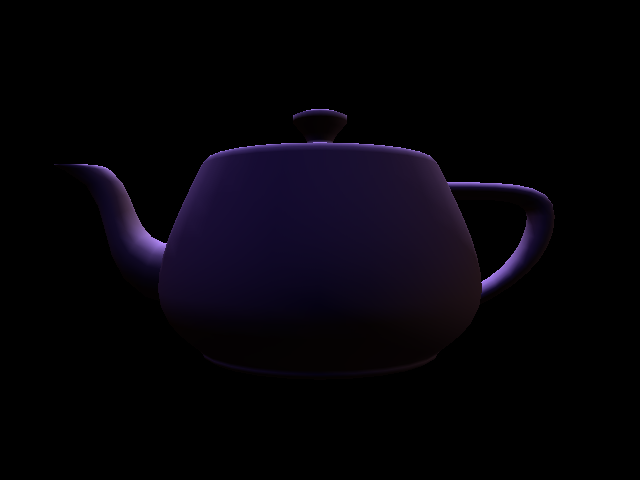

In [6]:
grace_probe_angular = cv2.imread('1_relighting/grace_probe.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
output_img = relighting_angular_map(teapot_imgs, teapot_ld, teapot_li, grace_probe_angular)
output_img = normalized_copy(output_img)
debug_draw_angular(teapot_imgs, teapot_ld, teapot_li, 'output/debug/task2_debug_angular.avi')
output_path = 'output/task2_angular_grace.png'
cv2.imwrite(output_path, output_img)
Image(output_path)

In [7]:
def rectangular_map_coords(dx, dy, dz):
    u = 1. + np.arctan2(dx, -dz) / np.pi
    v = 1. - np.arccos(dy) / np.pi
    if u >= 2 or u < 0.:
        u = 0.
    return u, v

def relighting_rectangular_map(data_imgs, light_directions, light_intensities, probe):
    img_shape = data_imgs[0].shape
    output_img = np.zeros(img_shape, np.float32)
    (probe_h, probe_w, probe_c) = probe.shape
    for i in range(len(data_imgs)):
        img = data_imgs[i]
        dx, dy, dz = light_directions[i]
        li = light_intensities[i]
        u_norm, v_norm = rectangular_map_coords(dx, dy, dz)
        u, v = int((u_norm)*probe_w/2.), int(v_norm*probe_h)
        output_img += img * (probe[v,u]*li)
    return output_img

In [8]:
def debug_draw_rectangular(data_imgs, light_directions, light_intensities, output_path):
    img_shape = data_imgs[0].shape
    cx, cy = img_shape[1]/2, img_shape[0]/2 
    video = cv2.VideoWriter(
        output_path,
        cv2.VideoWriter_fourcc(*'MJPG'),
        5,(img_shape[1],img_shape[0]))
    
    for i in log_progress(range(len(data_imgs))):
        img = data_imgs[i].copy()
        dx, dy, dz = light_directions[i]
        li = light_intensities[i]
        u_norm, v_norm = rectangular_map_coords(dx, dy, dz)
        u, v = int(u_norm*cx), int((v_norm-0.5)*cx+cy)
        draw_rectangle_on_center(img)
        draw_arrow(img,(cx,cy),(u,v))
        video.write(img)
    video.release()

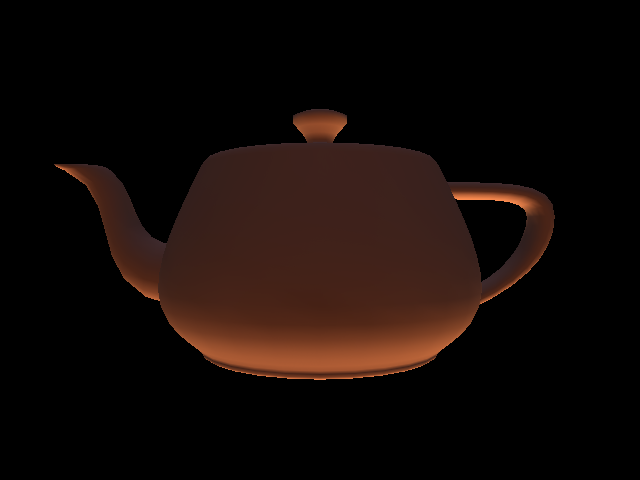

In [9]:
grace_probe_rectangular = cv2.imread('1_relighting/grace_probe_rect.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
output_img = relighting_rectangular_map(teapot_imgs, teapot_ld, teapot_li, grace_probe_rectangular)
output_img = normalized_copy(output_img)
debug_draw_rectangular(teapot_imgs, teapot_ld, teapot_li, 'output/debug/task2_debug_rectangular.avi')
output_path = 'output/task2_rectangular_grace.png'
cv2.imwrite(output_path, output_img)
Image(output_path)

### Bonus: Relighting from normals

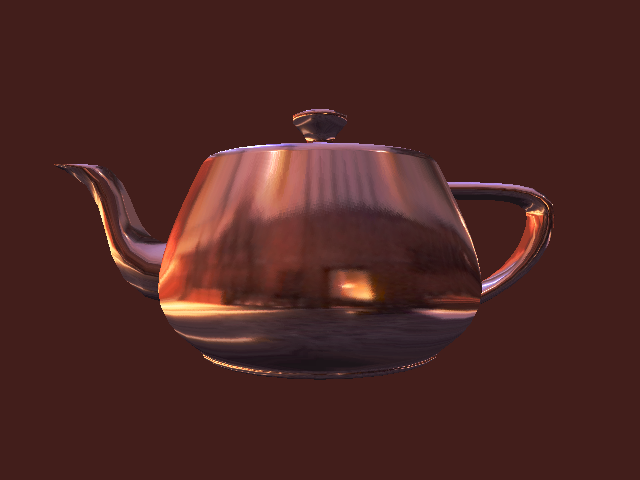

In [10]:
grace_angular_ldr = cv2.imread('1_relighting/grace_probe_tm.png')

def relighting_from_normals_angular_map(normals, probe):
    output_img = np.zeros_like(normals)
    (h, w, c) = normals.shape
    (probe_h, probe_w, probe_c) = probe.shape
    for y in log_progress(range(0, h)):
        for x in range(0, w):
            dx, dy, dz = normals[y,x]
            u_norm, v_norm = angular_map_coords(dx, dy, dz)
            u, v = int((u_norm+1.)*probe_w/2.), int((v_norm+1.)*probe_h/2.)
            output_img[y,x] = probe[v,u]
    return output_img

teapot_normals = compute_normals(teapot0_imgs, L)
output_img = relighting_from_normals_angular_map(teapot_normals, grace_angular_ldr)
output_img = normalized_copy(output_img)
output_path = 'output/task2_bonus_grace.png'
cv2.imwrite(output_path,output_img)
Image(output_path)

## Task 3: Real Dataset (20 pts)

Dataset from http://gl.ict.usc.edu/Data/LightStage/

In [11]:
knight_path = '3_realdata/knight_fighting/data'
knight_files = [join(knight_path, f) for f in listdir(knight_path) if isfile(join(knight_path, f))]
knight_files.sort()
knight_imgs = [cv2.imread(img_path).astype(np.float32) for img_path in knight_files]
with open('3_realdata/knight_fighting/light_directions.txt') as ld_file:
    lines = ld_file.readlines()
    knight_ld = [map(float, line.rstrip().split()[1:]) for line in lines]
    knight_ld = np.array([[-ld[0], ld[1], ld[2]] for ld in knight_ld], np.float32)
with open('3_realdata/knight_fighting/light_intensities.txt') as li_file:
    lines = li_file.readlines()
    knight_li = np.array([map(float, line.rstrip().split()[1:][::-1]) for line in lines], np.float32)

### a) angular map

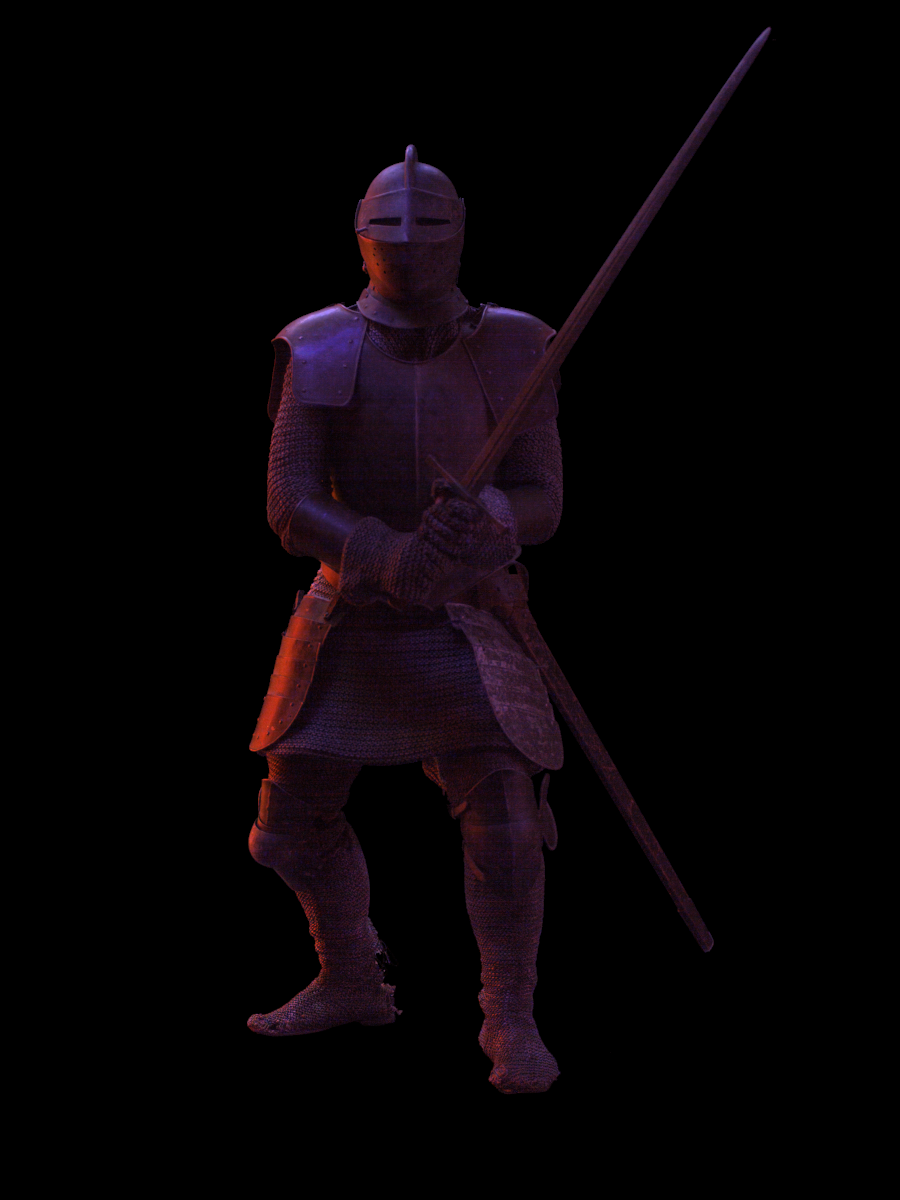

In [12]:
grace_probe = cv2.imread('1_relighting/grace_probe.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

output_img = relighting_angular_map(knight_imgs, knight_ld, knight_li, grace_probe)
output_img = normalized_copy(output_img)
debug_draw_angular(knight_imgs, knight_ld, knight_li, 'output/debug/task3_video_debug.avi')
output_path = 'output/task3_grace.png'
cv2.imwrite(output_path, output_img)
Image(output_path)

## b) rectangular map

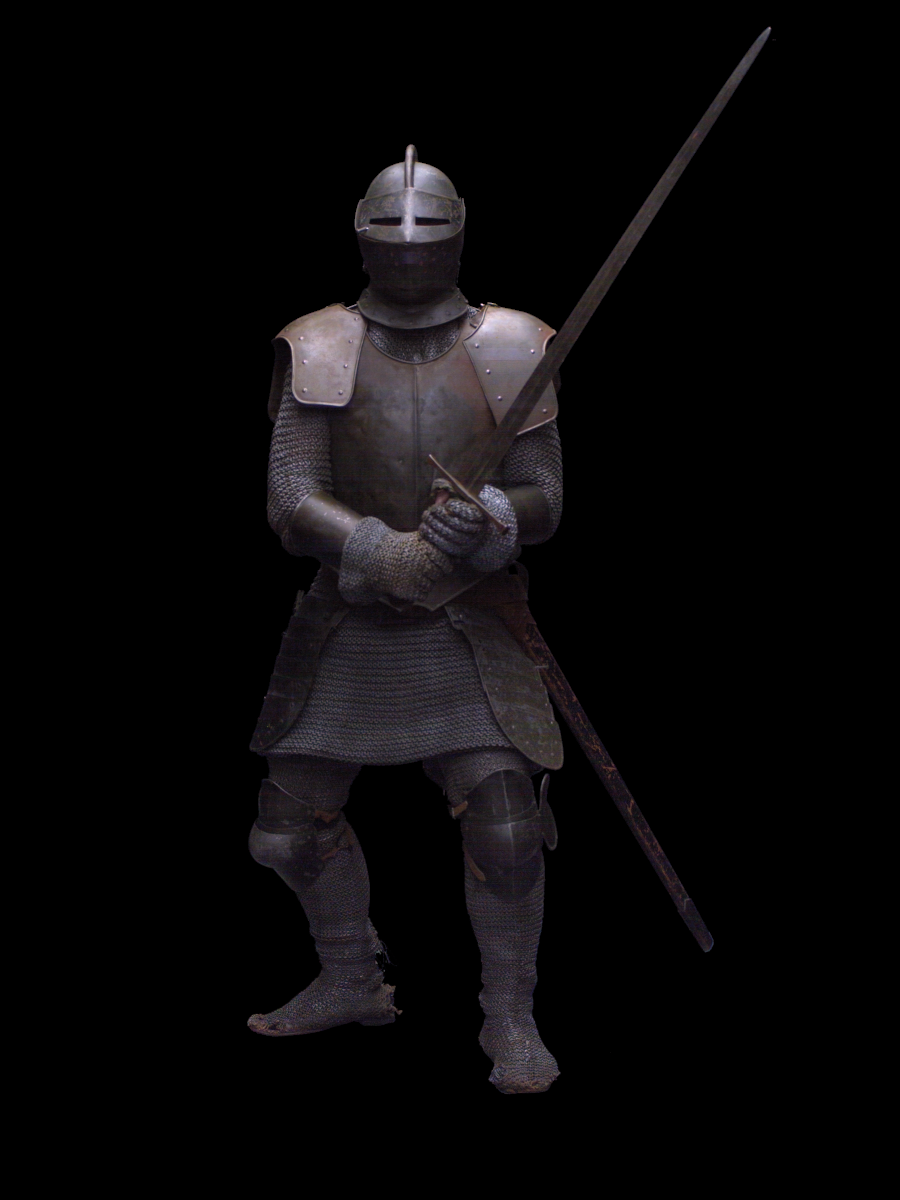

In [13]:
#grace_probe_rectangular = cv2.imread('1_relighting/grace_probe_rect.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
uffizi_probe_rectangular = cv2.imread('1_relighting/uffizi-large_rect.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

output_img = relighting_rectangular_map(knight_imgs, knight_ld, knight_li, uffizi_probe_rectangular)
output_img = normalized_copy(output_img)
debug_draw_rectangular(knight_imgs, knight_ld, knight_li, 'output/debug/task3_rect_video_debug.avi')
output_path = 'output/task3_uffizi_rect.png'
cv2.imwrite(output_path, output_img)
Image(output_path)

## Task 4: Video (20 pts)

## a) angular map

Without any interpolation or averaging.

In [14]:
def rotate_ld_function(M):
    return lambda info: np.dot(M, info)
    
def relighting_angular_map_rotating_video(data_imgs, light_directions, light_intensities, probe):
    img_shape = data_imgs[0].shape
    video = cv2.VideoWriter(
        'output/videos/relighting_angular_map.avi',
        cv2.VideoWriter_fourcc(*'MJPG'),
        30,(img_shape[1],img_shape[0]))
    
    nframes = 900
    factor = None
    for frame in log_progress(range(nframes), every=1):
        phi = 2.0*np.pi*(float(frame)/nframes)
        M = [[np.cos(phi), 0., np.sin(phi)],
             [0., 1., 0.],
             [-np.sin(phi), 0., np.cos(phi)]]        
        frame_light_directions = map(rotate_ld_function(M), light_directions)
        img = relighting_angular_map(data_imgs, frame_light_directions, light_intensities, probe)
        if not factor:
            factor = 255./np.max(img)
        img *= factor
        video.write(img.clip(0,255).astype(np.uint8))
    video.release()

In [ ]:
grace_probe = cv2.imread('1_relighting/grace_probe.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
relighting_angular_map_rotating_video(knight_imgs, knight_ld, knight_li, grace_probe)

## b) rectangular map

With mean of neighbours (filter_size).

In [16]:
def relighting_rectangular_map_rotating_video(data_imgs, light_directions, light_intensities, probe, filter_size=9):
    img_shape = data_imgs[0].shape
    
    # make probe border for filtering
    # BORDER_WRAP: fgh|abcdefgh|abc
    (probe_h, probe_w, probe_c) = probe.shape
    df = int(filter_size/2)
    probe_with_border = cv2.copyMakeBorder(probe, df, df, df, df, cv2.BORDER_WRAP)
    
    # blur probe
    blurred_probe_with_border = cv2.GaussianBlur(
        probe_with_border, 
        (filter_size,filter_size), 0)
    blurred_probe = blurred_probe_with_border[df:-df, df:-df]
    
    video = cv2.VideoWriter(
        'output/videos/relighting_rectangular_map.avi',
        cv2.VideoWriter_fourcc(*'MJPG'),
        30, (img_shape[1],img_shape[0]))
    
    # compute UVs once
    probe_wc = probe_w/2.
    uvs = np.empty((len(data_imgs), 2), np.int)
    uvs[...,0] = probe_wc + np.arctan2(light_directions[...,0], -light_directions[...,2]) * (probe_wc/np.pi)
    uvs[...,1] = probe_h - np.arccos(light_directions[...,1]) * (probe_h/np.pi)
    
    # compute frames by shifting U coordinate
    nframes = 1024
    factor = None
    for frame in log_progress(range(nframes), every=1):
        output_frame = np.zeros(img_shape, np.float32)
        u_offset = int((float(frame)/nframes)*probe_w)
        
        for i in range(len(data_imgs)):
            img = data_imgs[i]
            u, v = uvs[i]
            u = (u+u_offset)%probe_w
            li = light_intensities[i]
            
            output_frame += img * (blurred_probe[v,u]*li)
        if not factor:
            factor = 255./np.max(output_frame)
        output_frame *= factor
        
        video.write(output_frame.clip(0,255).astype(np.uint8))
    video.release()

In [ ]:
#grace_probe_rectangular = cv2.imread('1_relighting/grace_probe_rect.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
#uffizi_probe_rectangular = cv2.imread('1_relighting/uffizi-large_rect.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
pisa_probe_rectangular = cv2.imread('1_relighting/pisa_rect.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

relighting_rectangular_map_rotating_video(knight_imgs, knight_ld, knight_li, pisa_probe_rectangular)